In [1]:
# Start with the Ravi et al. method - combine directories, see range of view counts, discriminate range of views,
# Discriminate range by getting histogram of views (per category?), taking only top 1/2? Cap at 1 stdev below median?
# calculate ratio of views to score, calculate ratio of answers to score, see how well it regresses
# View count will be skewed by category - don't want end result to be just Physics

In [2]:
# Use sqlite file for output
import sqlite3
import pandas
con = sqlite3.connect('SO_quality.db')
cur = con.cursor()

In [3]:
cur.execute("drop table if exists data;")
cur.execute(
"create table data( \
    id int, \
    ViewCount int, \
    AnswerCount int, \
    Score int, \
    ViewRatio float, \
    AnswerRatio float, \
    Category varchar \
);")
from xml.dom import minidom
categories =['earthscience', 'physics', 'chemistry', 'astronomy', 'biology']
for category in categories:
    xmldoc = minidom.parse(category + '.stackexchange.com/Posts.xml')
    postlist = xmldoc.getElementsByTagName('row')
    to_db = []
    for post in postlist:
        if int(post.attributes['PostTypeId'].value) is not 1:
            continue
        post_id = int(post.attributes['Id'].value)
        ViewCount = int(post.attributes['ViewCount'].value)
        AnswerCount = int(post.attributes['AnswerCount'].value)
        Score = int(post.attributes['Score'].value)
        ViewRatio = float(Score) / ViewCount
        AnswerRatio = float(Score) / AnswerCount if AnswerCount > 0 else None
        to_db.append((post_id, ViewCount, AnswerCount, Score, ViewRatio, AnswerRatio, category))
    cur.executemany("insert into data (id, ViewCount, AnswerCount, Score, ViewRatio, AnswerRatio, Category ) \
                 VALUES (?, ?, ?, ?, ?, ?, ?);", to_db)

In [4]:
import pandas
import matplotlib.pyplot as plt
# Convert to histograms of view counts! And answer counts!
ViewTable = pandas.read_sql('select ViewCount from data', con) # Plot as histogram!
AnswerTable = pandas.read_sql('select AnswerCount from data where ViewCount > 100 AND ViewCount < 10000', con) # Plot as histogram!
CompTable = pandas.read_sql('select ViewCount, AnswerCount from data where ViewCount > 100 AND ViewCount < 10000', con) # Plot as scatter!

In [5]:
print(pandas.read_sql('select Category, count(*) from data  GROUP BY Category', con))
print(pandas.read_sql('select Category, count(*) from data where ViewCount > 100 GROUP BY Category', con))
print(pandas.read_sql('select Category, count(*) from data where ViewCount > 1000 GROUP BY Category', con))
print(pandas.read_sql('select Category, count(*) from data where ViewCount > 10000 GROUP BY Category', con))

       Category  count(*)
0     astronomy      5727
1       biology     19052
2     chemistry     25597
3  earthscience      3500
4       physics    115263
       Category  count(*)
0     astronomy      3907
1       biology     11651
2     chemistry     18068
3  earthscience      2160
4       physics     76711
       Category  count(*)
0     astronomy       662
1       biology      3447
2     chemistry      6077
3  earthscience       451
4       physics     19686
       Category  count(*)
0     astronomy        54
1       biology       510
2     chemistry       902
3  earthscience        49
4       physics      2309


(array([9.1890e+03, 5.2940e+04, 2.8475e+04, 1.1161e+04, 4.0480e+03,
        1.6320e+03, 6.4900e+02, 2.9000e+02, 1.2600e+02, 6.6000e+01,
        4.6000e+01, 2.1000e+01, 1.3000e+01, 4.0000e+00, 6.0000e+00,
        1.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]),
 <a list of 24 Patch objects>)

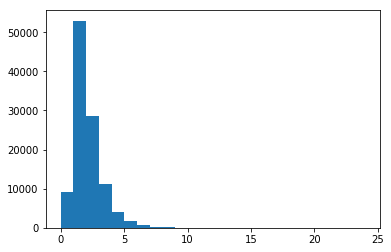

In [6]:
plt.hist(AnswerTable.values, 24)

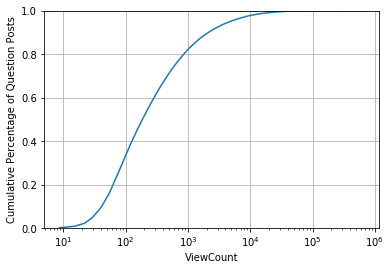

In [7]:
from scipy.stats import cumfreq
import matplotlib.pyplot as plt
import numpy
counts, bin_edges = numpy.histogram(ViewTable.values, bins=100000)
cdf = numpy.cumsum(counts)
cdf = cdf / max(cdf)
plt.semilogx(bin_edges[1:], cdf)
plt.xlabel('ViewCount')
plt.ylabel('Cumulative Percentage of Question Posts')
plt.ylim([0,1])
plt.grid()
plt.savefig('Graphs/cum_dist.png')
plt.show()

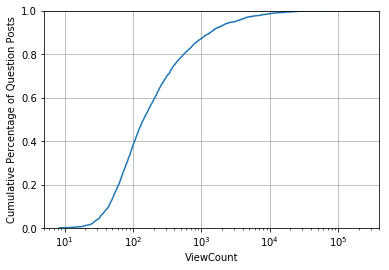

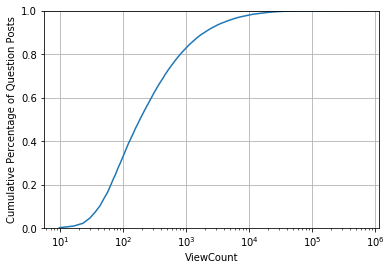

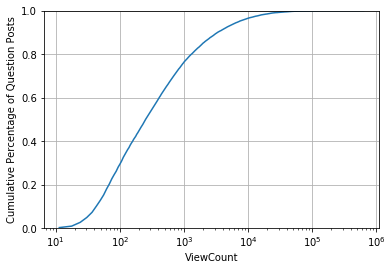

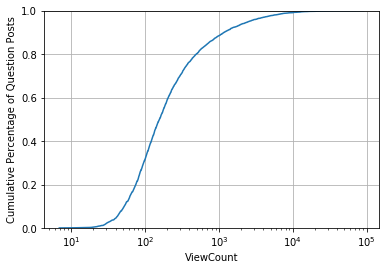

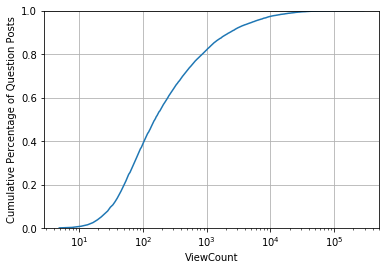

In [8]:
for category in categories:
    data = pandas.read_sql('select ViewCount from data where Category is "' + category + '"', con) # Plot as histogram!
    counts, bin_edges = numpy.histogram(data.values, bins=100000)
    cdf = numpy.cumsum(counts)
    cdf = cdf / max(cdf)
    plt.semilogx(bin_edges[1:], cdf)
    plt.xlabel('ViewCount')
    plt.ylabel('Cumulative Percentage of Question Posts')
    plt.ylim([0,1])
    plt.grid()
    plt.savefig('Graphs/cum_dist_' + category + '.png')
    plt.show()

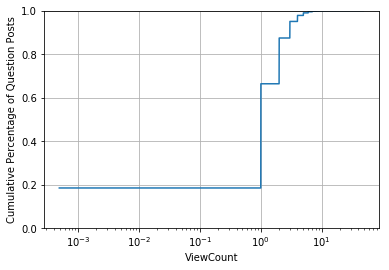

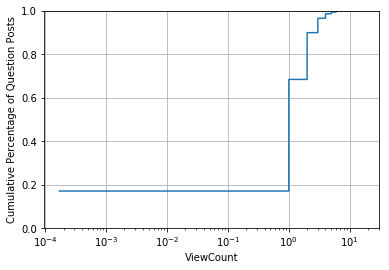

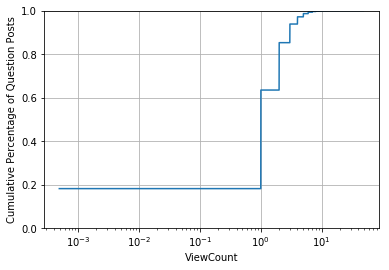

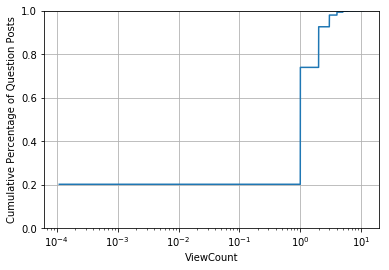

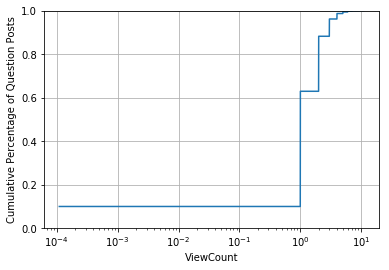

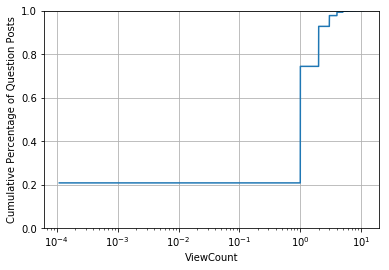

In [9]:
data = pandas.read_sql('select AnswerCount from data', con)
counts, bin_edges = numpy.histogram(data.values, bins=100000)
cdf = numpy.cumsum(counts)
cdf = cdf / max(cdf)
plt.semilogx(bin_edges[1:], cdf)
plt.xlabel('ViewCount')
plt.ylabel('Cumulative Percentage of Question Posts')
plt.ylim([0,1])
plt.grid()
plt.savefig('Graphs/ans_cum_dist.png')
plt.show()
for category in categories:
    data = pandas.read_sql('select AnswerCount from data where Category is "' + category + '"', con) # Plot as histogram!
    counts, bin_edges = numpy.histogram(data.values, bins=100000)
    cdf = numpy.cumsum(counts)
    cdf = cdf / max(cdf)
    plt.semilogx(bin_edges[1:], cdf)
    plt.xlabel('ViewCount')
    plt.ylabel('Cumulative Percentage of Question Posts')
    plt.ylim([0,1])
    plt.grid()
    plt.savefig('Graphs/ans_cum_dist_' + category + '.png')
    plt.show()

In [10]:
ViewRatioTable = pandas.read_sql('select ViewRatio from data where AnswerRatio is NOT NULL', con)
AnswerRatioTable = pandas.read_sql('select AnswerRatio from data where AnswerRatio is NOT NULL', con)
ViewRatioTable_NonNegScores = pandas.read_sql('select ViewRatio from data where Score >= 0 AND AnswerRatio is NOT NULL', con)
AnswerRatioTable_NonNegScores = pandas.read_sql('select AnswerRatio from data where Score >= 0 AND AnswerRatio is NOT NULL', con)

In [11]:
Avg_ViewRatioTable = numpy.average(ViewRatioTable.values)
Avg_AnswerRatioTable = numpy.average(AnswerRatioTable.values) 
Avg_ViewRatioTable_NonNegScores = numpy.average(ViewRatioTable_NonNegScores.values)
Avg_AnswerRatioTable_NonNegScores = numpy.average(AnswerRatioTable_NonNegScores.values)
print(Avg_ViewRatioTable)
print(Avg_AnswerRatioTable)
print(Avg_ViewRatioTable_NonNegScores)
print(Avg_AnswerRatioTable_NonNegScores)
# Define bad: question with 0 score in either category.
# Define good: Greater than 1/2 of average
# See how many are classified as good or bad in each case, how much overlap there is 

0.009127214229735624
1.9991064121666662
0.010982999613078002
2.2316573149445924


In [12]:
print(pandas.read_sql('select Category, count(*) from data where ViewCount > 100 AND ViewRatio > ' + 
                      str(Avg_ViewRatioTable_NonNegScores) + ' GROUP BY Category', con))
print(pandas.read_sql('select Category, count(*) from data where AnswerRatio is NOT NULL AND AnswerRatio > ' + 
                      str(Avg_AnswerRatioTable_NonNegScores) + ' GROUP BY Category', con))
print(pandas.read_sql('select Category, count(*) from data where ViewCount > 100 AND Score = 0 GROUP BY Category', con))
print(pandas.read_sql('select Category, count(*) from data where Score = 0 AND AnswerRatio is NOT NULL GROUP BY Category', con))

       Category  count(*)
0     astronomy      1848
1       biology      3976
2     chemistry      4289
3  earthscience      1400
4       physics     15665
       Category  count(*)
0     astronomy      2212
1       biology      6800
2     chemistry      8064
3  earthscience      2064
4       physics     21209
       Category  count(*)
0     astronomy       309
1       biology       824
2     chemistry      2406
3  earthscience        48
4       physics     15204
       Category  count(*)
0     astronomy       579
1       biology      1701
2     chemistry      3010
3  earthscience       112
4       physics     24426


In [13]:
# Assessing similarities of the metrics across the things 
print("These are categorized as good with both view ratio and answer ratio:")
print(pandas.read_sql('select Category, count(*) from data where ViewCount > 100 AND AnswerRatio is NOT NULL AND ViewRatio > ' + 
                      str(Avg_ViewRatioTable_NonNegScores) + ' AND AnswerRatio > ' + 
                      str(Avg_AnswerRatioTable_NonNegScores) + ' GROUP BY Category', con))

These are categorized as good with both view ratio and answer ratio:
       Category  count(*)
0     astronomy      1304
1       biology      2861
2     chemistry      3089
3  earthscience      1177
4       physics      8884


In [14]:
print("These are categorized as good with view ratio and bad with answer ratio:")
print(pandas.read_sql('select Category, count(*) from data where ViewCount > 100 AND (AnswerRatio is NULL OR Score is 0) \
                      AND ViewRatio > ' + str(Avg_ViewRatioTable_NonNegScores)  + ' GROUP BY Category', con))

These are categorized as good with view ratio and bad with answer ratio:
       Category  count(*)
0     astronomy        55
1       biology       271
2     chemistry       463
3  earthscience        76
4       physics      1878


In [15]:
print("These are categorized as bad with view ratio and good with answer ratio:")
print(pandas.read_sql('select Category, count(*) from data where (ViewCount <= 100 OR Score is 0) AND AnswerRatio is NOT NULL AND \
                      AnswerRatio > ' + str(Avg_AnswerRatioTable_NonNegScores)  + ' GROUP BY Category', con))

These are categorized as bad with view ratio and good with answer ratio:
       Category  count(*)
0     astronomy       338
1       biology      1028
2     chemistry       853
3  earthscience       423
4       physics      1548


In [18]:
print("These are categorized as bad with both view ratio and answer ratio:")
print(pandas.read_sql('select Category, count(*) from data where (ViewCount <= 100 AND AnswerRatio is NULL) AND Score = 0 \
                      GROUP BY Category', con))

These are categorized as bad with both view ratio and answer ratio:
       Category  count(*)
0     astronomy       118
1       biology      1032
2     chemistry      1070
3  earthscience        60
4       physics      6760


In [ ]:
print("These are categorized as bad with view ratio and as intermediate by answer ratio:")
print(pandas.read_sql('select Category, count(*) from data where (ViewCount <= 100 AND AnswerRatio is NULL) AND Score = 0 \
                      GROUP BY Category', con))